# Import Modules

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
from numpy import asarray
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import * 
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras import backend as K
from tensorflow.keras import losses
from tensorflow.keras.utils import plot_model

np.random.seed(1)
from tensorflow.random import set_seed
set_seed(2)

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4343198420256357860
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14674281152
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1324272035298647766
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
PATH = "/content/drive/My Drive/PY/SemEval2021/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Prepare Data

In [ ]:
import re
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords,wordnet
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')
stopwordEn = stopwords.words('english')
def lemmaWord(word):
    lemma = wordnet.morphy(word) 
    # lemmar = WordNetLemmatizer()
    # lemma = lemmar.lemmatize(word) 
    if lemma is not None:
        return lemma
    else:
        return word
def processText(text,lemma=False, gram=1, rmStop=True): # default remove stop words
    text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b|@\w+|#', '', text, flags=re.MULTILINE) #delete URL, #hashtag# , and @xxx
    tokens = word_tokenize(text)
    whitelist = ["n't", "not", "no"]
    new_tokens = []
    stoplist = stopwordEn if rmStop else []
    for i in tokens:
      i = i.lower()
      if i not in ['.',',',';'] and (i not in stoplist or i in whitelist):  #i.isalpha() and (...)
        if lemma: i = lemmaWord(i)
        new_tokens.append(i)
    del tokens
    # tokens = [lemmaWord(i.lower()) if lemma else i.lower() for i in tokens if (i.lower() not in stoplist or i.lower() in whitelist) and i.isalpha()]
    if gram<=1:
        return new_tokens
    else:
        return [' '.join(i) for i in nltk.ngrams(new_tokens, gram)]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
data = pd.read_csv(PATH+"train.csv")
data.loc[:,'tokens'] = [processText(t, rmStop=True) for t in data.text]
data.loc[:,'token_len'] = [len(t) for t in data.tokens]
data['humor_rating'] = data['humor_rating'].fillna(0)
data.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/dtypes/missing.py:495: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  val = np.array(val, copy=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,id,text,is_humor,humor_rating,humor_controversy,offense_rating,tokens,token_len
0,1,TENNESSEE: We're the best state. Nobody even c...,1,2.42,1.0,0.2,"[tennessee, :, 're, best, state, nobody, even,...",17
1,2,A man inserted an advertisement in the classif...,1,2.50,1.0,1.1,"[man, inserted, advertisement, classifieds, ``...",24
2,3,How many men does it take to open a can of bee...,1,1.95,0.0,2.4,"[many, men, take, open, beer, ?, none, open, t...",11
3,4,Told my mom I hit 1200 Twitter followers. She ...,1,2.11,1.0,0.0,"[told, mom, hit, 1200, twitter, followers, poi...",17
4,5,Roses are dead. Love is fake. Weddings are bas...,1,2.78,0.0,0.1,"[roses, dead, love, fake, weddings, basically,...",8


Import from saved pickle

In [ ]:
PATH

'/content/drive/My Drive/PY/SemEval2021/'

In [ ]:
data.loc[:,['text','is_humor']].to_csv(PATH+'text_humor.csv', index=False)

In [ ]:
with open(PATH+'train_tokens.pickle', 'rb') as handle:
    data = pickle.load(handle)

NameError: ignored

## Pre-Trained GloVe Embedding
Download GloVe: https://drive.google.com/drive/folders/1HjR7uSYHPoC2qp2rUwgnz2mwdD63kYLf?usp=sharing

In [ ]:
# load the whole embedding into memory
EMB_DIM = 50
embeddings_dict = {}
with open(PATH+F"./GLOVE/glove.twitter.27B.{EMB_DIM}d.txt", 'rb') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        if len(vector)==EMB_DIM:
            embeddings_dict[word] = vector
print('Loaded %s word vectors.' % len(embeddings_dict))

Loaded 1193514 word vectors.


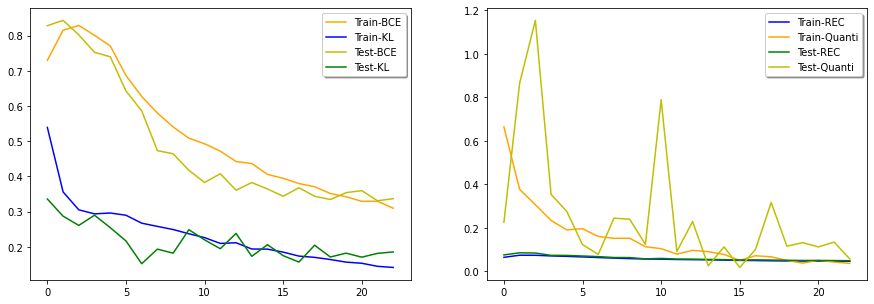

In [ ]:
# def VisRes(res):
#     plt.figure(figsize=(15,5))
#     plt.subplot('121')
#     # plt.plot(list(res.history.values())[0],'magenta',label='Train-Loss')
#     plt.plot(list(res.history.values())[1],'orange',label='Train-BCE')
#     plt.plot(list(res.history.values())[3],'b',label='Train-KL')
#     # plt.plot(list(res.history.values())[5],'cyan',label='Test-Loss')
#     plt.plot(list(res.history.values())[6],'y',label='Test-BCE')
#     plt.plot(list(res.history.values())[8],'g',label='Test-KL')
#     plt.legend(loc='best', shadow=True)
#     plt.subplot('122')
#     plt.plot(list(res.history.values())[2],'b',label='Train-REC')
#     plt.plot(list(res.history.values())[4],'orange',label='Train-Quanti')
#     plt.plot(list(res.history.values())[7],'g',label='Test-REC')
#     plt.plot(list(res.history.values())[9],'y',label='Test-Quanti')
#     plt.legend(loc='best', shadow=True)
#     plt.show()
# VisRes(res_cusLSTM)

# Modelling

## DistilBERT
http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/

In [ ]:
!pip install transformers

     |████████████████████████████████| 1.8MB 17.2MB/s 
     |████████████████████████████████| 890kB 25.4MB/s 
     |████████████████████████████████| 3.2MB 50.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=853b20f4d604774d03ebd2ea19b06fbf7346f439cd432127fbc4f92df4492fd9
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import torch
import transformers as ppb

In [ ]:
# For DistilBERT:
# model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [ ]:
tokenized = data['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [ ]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)
max_len

136

In [ ]:
padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
np.array(padded).shape

(8000, 136)

In [ ]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(8000, 136)

In [ ]:
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

In [ ]:
last_hidden_states[0].shape

torch.Size([2000, 78, 768])

In [ ]:
from sklearn.linear_model import LogisticRegression
features = last_hidden_states[0][:,0,:].numpy()
labels = data['is_humor']
lr_clf = LogisticRegression()
lr_clf.fit(features, labels)

In [ ]:
data_dev = pd.read_csv(PATH+"public_dev.csv")
dev_tokenized = data_dev['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

dev_padded = np.array([i[:max_len] + [0]*(max_len-len(i)) for i in dev_tokenized.values])
dev_attention_mask = np.where(dev_padded != 0, 1, 0)
dev_input_ids = torch.tensor(dev_padded)  
dev_attention_mask = torch.tensor(dev_attention_mask)

In [ ]:
with torch.no_grad():
    dev_last_hidden_states = model(dev_input_ids, attention_mask=dev_attention_mask)

dev_features = dev_last_hidden_states[0][:,0,:].numpy()
dev_labels = pd.read_csv(PATH+'dev.csv')['is_humor']

lr_clf.score(dev_features, dev_labels)

In [ ]:
dev_last_hidden_states[0][:,0,:].shape

torch.Size([1000, 768])

In [ ]:
y_pred = lr_clf.predict(dev_features)
print(classification_report(y_pred, dev_labels))

              precision    recall  f1-score   support

           0       0.71      0.83      0.77       318
           1       0.91      0.85      0.88       682

    accuracy                           0.84      1000
   macro avg       0.81      0.84      0.82      1000
weighted avg       0.85      0.84      0.84      1000



In [ ]:
features = last_hidden_states[0].numpy()
labels = data['is_humor']
dev_features = dev_last_hidden_states[0].numpy()
dev_labels = pd.read_csv(PATH+'dev.csv')['is_humor']

model1 = Sequential()
model1.add(Input(shape=(78, 768)))
model1.add(Conv1D(50,kernel_size=2, padding="valid",activation="relu"))
model1.add(Dense(1, activation="sigmoid"))

model1.compile(optimizer='adam', loss='binary_crossentropy',metrics='acc')
model1.fit(features, labels, batch_size=32, epochs=23, validation_data=(dev_features,dev_labels))

Epoch 1/23
63/63 [==============================] - 1s 14ms/step - loss: 0.4982 - acc: 0.7579 - val_loss: 0.4142 - val_acc: 0.8054
Epoch 2/23
63/63 [==============================] - 1s 10ms/step - loss: 0.3217 - acc: 0.8664 - val_loss: 0.3925 - val_acc: 0.8156
Epoch 3/23
63/63 [==============================] - 1s 10ms/step - loss: 0.2621 - acc: 0.8927 - val_loss: 0.3851 - val_acc: 0.8207
Epoch 4/23
63/63 [==============================] - 1s 10ms/step - loss: 0.2695 - acc: 0.8896 - val_loss: 0.3886 - val_acc: 0.8216
Epoch 5/23
63/63 [==============================] - 1s 10ms/step - loss: 0.2575 - acc: 0.8927 - val_loss: 0.3990 - val_acc: 0.8168
Epoch 6/23
63/63 [==============================] - 1s 10ms/step - loss: 0.2388 - acc: 0.9018 - val_loss: 0.4016 - val_acc: 0.8207
Epoch 7/23
63/63 [==============================] - 1s 10ms/step - loss: 0.2265 - acc: 0.9076 - val_loss: 0.3827 - val_acc: 0.8249
Epoch 8/23
63/63 [==============================] - 1s 10ms/step - loss: 0.2164 - a

## Bert Tokenizer

In [ ]:
# https://swatimeena989.medium.com/bert-text-classification-using-keras-903671e0207d
from transformers import *
from transformers import BertTokenizer, TFBertModel, BertConfig
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2)

In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
sent= 'how to train the model, lets look at how a trained model calculates its prediction.'
tokenized_sequence= bert_tokenizer.encode_plus(sent,add_special_tokens = True,max_length =30,pad_to_max_length = True,
return_attention_mask = True)
tokenized_sequence

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2143: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


{'input_ids': [101, 2129, 2000, 3345, 1996, 2944, 1010, 11082, 2298, 2012, 2129, 1037, 4738, 2944, 18422, 2015, 2049, 17547, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

In [ ]:
bert_tokenizer.decode(tokenized_sequence['input_ids'])

'[CLS] how to train the model, lets look at how a trained model calculates its prediction. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

## Bert+CNN model
Only Bert tokenizer
https://stackabuse.com/text-classification-with-bert-tokenizer-and-tf-2-0-in-python/


In [ ]:
!pip install bert-for-tf2
# !pip install sentencepiece

In [ ]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence

TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
    return TAG_RE.sub('', text)

texts = []
sentences = list(data['text'])
for sen in sentences:
    texts.append(preprocess_text(sen))

In [ ]:
# y = to_categorical(data['is_humor'])
y = data['is_humor']
y

0       1
1       1
2       1
3       1
4       1
       ..
7995    0
7996    1
7997    1
7998    1
7999    0
Name: is_humor, Length: 8000, dtype: int64

In [ ]:
# BERT tokenizer
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import bert
BertTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=True)
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

# module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'

In [ ]:
print(tokenizer.tokenize(texts[0]))

['tennessee', 'we', 're', 'the', 'best', 'state', 'nobody', 'even', 'comes', 'close', 'eleven', '##ness', '##ee', 'walks', 'into', 'the', 'room', 'tennessee', 'oh', 'shit']


In [ ]:
tokenizer.convert_tokens_to_ids(['we'])

[2057]

In [ ]:
def tokenize_text(text):
    return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text))

tokenized_text = [tokenize_text(t) for t in texts]

In [ ]:
text_with_len = [[t, y[i], len(t)] # 3 items: text token, label, length 
                 for i, t in enumerate(tokenized_text)]

In [ ]:
import random
random.seed(1)
random.shuffle(text_with_len)
text_with_len.sort(key=lambda x: x[2]) #  sort the data by the length 
sorted_text_labels = [(i[0], i[1]) for i in text_with_len] # delete length items
sorted_text_labels[0]

([26452], 0)

In [ ]:
tokenizer.convert_ids_to_tokens([5798])

['birthday']

In [ ]:
processed_dataset = tf.data.Dataset.from_generator(lambda: sorted_text_labels, output_types=(tf.int32, tf.int32))
BATCH_SIZE = 32
batched_dataset = processed_dataset.padded_batch(BATCH_SIZE, padded_shapes=((None, ), ( )))

In [ ]:
sorted_text_labels[:2]

[([26452], 0), ([4067, 2279], 0)]

In [ ]:
next(iter(batched_dataset))

(<tf.Tensor: shape=(32, 5), dtype=int32, numpy=
 array([[26452,     0,     0,     0,     0],
        [ 4067,  2279,     0,     0,     0],
        [ 3407,  5798,     0,     0,     0],
        [12831,  4234,  3071,     0,     0],
        [11839,  2005,  3000,     0,     0],
        [ 8827,  2208, 11433,     0,     0],
        [ 2777,  5637,  2721,     0,     0],
        [15531,  2003,  9580,     0,     0],
        [ 3407,  5798,  5035,     0,     0],
        [ 4474,  4474,  4474,     0,     0],
        [ 2748, 10768,  5244,     0,     0],
        [ 1999,  7401,  1997,     0,     0],
        [ 2308, 17757, 10474,     0,     0],
        [ 7610,  8827,  2102,     0,     0],
        [ 2888,  2417, 18115,     0,     0],
        [ 4301,  1998, 12583, 10108,     0],
        [20976,  2085,  2009,  2908,     0],
        [ 1997,  4083,  2003,  5107,     0],
        [ 2748,  1049,  2428,  3331,     0],
        [ 2655,  2033,  3449, 21418,     0],
        [15854,  6806,  2080,  1049,  2182],
       

In [ ]:
import math
TOTAL_BATCHES = math.ceil(len(sorted_text_labels) / BATCH_SIZE)
TEST_BATCHES = TOTAL_BATCHES // 10
batched_dataset.shuffle(TOTAL_BATCHES)
test_data = batched_dataset.take(TEST_BATCHES)
train_data = batched_dataset.skip(TEST_BATCHES)

In [ ]:
# Modelling
class TEXT_MODEL(tf.keras.Model):
    
    def __init__(self,
                 vocabulary_size,
                 emb_matrix,
                 embedding_dimensions=128,
                 cnn_filters=50,
                 dnn_units=512,
                 dropout_rate=0.1,
                 training=False,
                 name="text_model"):
        super(TEXT_MODEL, self).__init__(name=name)
        
        self.embedding = layers.Embedding(vocabulary_size,
                                          embedding_dimensions,weights=[emb_matrix], trainable=True)
        self.cnn_layer1 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=2,
                                        padding="valid",
                                        activation="relu")
        self.cnn_layer2 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=3,
                                        padding="valid",
                                        activation="relu")
        self.cnn_layer3 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=4,
                                        padding="valid",
                                        activation="relu")
        self.pool = layers.GlobalMaxPool1D()
        
        self.dense_1 = layers.Dense(units=dnn_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        self.last_dense = layers.Dense(units=1, activation="sigmoid")
    
    def call(self, inputs, training):
        l = self.embedding(inputs)
        l_1 = self.cnn_layer1(l) 
        l_1 = self.pool(l_1) 
        l_2 = self.cnn_layer2(l) 
        l_2 = self.pool(l_2)
        l_3 = self.cnn_layer3(l)
        l_3 = self.pool(l_3) 
        
        concatenated = tf.concat([l_1, l_2, l_3], axis=-1) # (batch_size, 3 * cnn_filters)
        concatenated = self.dense_1(concatenated)
        concatenated = self.dropout(concatenated, training)
        model_output = self.last_dense(concatenated)
        
        return model_output

In [ ]:
# class LSTM_MODEL(tf.keras.Model):
    
#     def __init__(self,
#                  vocabulary_size,
#                  emb_matrix,
#                  embedding_dimensions=100,
#                  training=False,
#                  name="lstm_model"):
#         super(LSTM_MODEL, self).__init__(name=name)
        
#         self.embedding = Embedding(vocabulary_size,
#                                           embedding_dimensions,weights=[emb_matrix], trainable=True)
#         self.lstm_layer1 = LSTM(32, return_sequences=True, kernel_regularizer=regularizers.l2(0.001),
#                                 kernel_initializer='he_uniform')
#         self.lstm_layer2 = LSTM(32, return_sequences=True, kernel_regularizer=regularizers.l2(0.001),
#                                 kernel_initializer='he_uniform')
#         self.dense_layer1 = Dense(16, activation='relu')

#         self.last_dense = Dense(2, activation='sigmoid')
    
#     def call(self, inputs, training):
#         l = self.embedding(inputs)
#         l = self.lstm_layer1(l) 
#         l = Dropout(0.5)(l) 
#         l = self.lstm_layer2(l) 
#         l = Dropout(0.2)(l)
#         l = Flatten()(l) 
#         l = self.dense_layer1(l)
#         l = Dropout(0.1)(l)

#         model_output = self.last_dense(l)
        
#         return model_output

In [ ]:
# lstm_model = LSTM_MODEL(vocabulary_size=VOCAB_LENGTH,embedding_dimensions=EMB_DIM,emb_matrix = emb_matrix)
# lstm_model.compile(loss="binary_crossentropy",
#                        optimizer="rmsprop",
#                        metrics=["accuracy"])
# lstm_model.fit(train_data, epochs=23,validation_data=test_data)

In [ ]:
VOCAB_LENGTH = len(tokenizer.vocab)
EMB_DIM = 50
CNN_FILTERS = 100
DNN_UNITS = 256
OUTPUT_CLASSES = 2
DROPOUT_RATE = 0.2
NB_EPOCHS = 23

In [ ]:
emb_matrix = np.zeros((VOCAB_LENGTH, EMB_DIM))

for w, i in tokenizer.vocab.items():
    # The word_index contains a token for all words of the training data so we need to limit that
    if i < VOCAB_LENGTH:
        vect = embeddings_dict.get(bytes(w, 'utf-8'))
        # Check if the word from the training data occurs in the GloVe word embeddings
        # Otherwise the vector is kept with only zeros
        if vect is not None:
            emb_matrix[i] = vect
    else:
        break
emb_matrix.shape

(30522, 50)

In [ ]:
text_model = TEXT_MODEL(vocabulary_size=VOCAB_LENGTH,
                        embedding_dimensions=EMB_DIM,
                        cnn_filters=CNN_FILTERS,
                        dnn_units=DNN_UNITS,
                        dropout_rate=DROPOUT_RATE,
                        emb_matrix = emb_matrix)
text_model.compile(loss="binary_crossentropy",
                       optimizer="rmsprop",
                       metrics=["accuracy"])

In [ ]:
text_model.fit(train_data, epochs=NB_EPOCHS,validation_data=test_data) # cnn

Epoch 1/23
57/57 [==============================] - 5s 71ms/step - loss: 0.6859 - accuracy: 0.6459 - val_loss: 0.9239 - val_accuracy: 0.5521
Epoch 2/23
57/57 [==============================] - 1s 19ms/step - loss: 0.5153 - accuracy: 0.7613 - val_loss: 0.6092 - val_accuracy: 0.7240
Epoch 3/23
57/57 [==============================] - 1s 20ms/step - loss: 0.3561 - accuracy: 0.8402 - val_loss: 0.5812 - val_accuracy: 0.7552
Epoch 4/23
57/57 [==============================] - 1s 19ms/step - loss: 0.2567 - accuracy: 0.8999 - val_loss: 0.5068 - val_accuracy: 0.8021
Epoch 5/23
57/57 [==============================] - 1s 20ms/step - loss: 0.1690 - accuracy: 0.9341 - val_loss: 0.5433 - val_accuracy: 0.7969
Epoch 6/23
57/57 [==============================] - 1s 19ms/step - loss: 0.1013 - accuracy: 0.9668 - val_loss: 0.7662 - val_accuracy: 0.7812
Epoch 7/23
57/57 [==============================] - 1s 20ms/step - loss: 0.0864 - accuracy: 0.9720 - val_loss: 1.0834 - val_accuracy: 0.7344
Epoch 8/23
57

In [ ]:
results = text_model.evaluate(test_data)
print(results)

6/6 [==============================] - 0s 13ms/step - loss: 1.4499 - accuracy: 0.7969
[1.449928641319275, 0.796875]


In [ ]:
# dev set
dev_texts = [] 
for s in data_dev.text:
  dev_texts.append(preprocess_text(s))
dev_tokenized_texts = [tokenize_text(t) for t in dev_texts]

dev_processed_dataset = tf.data.Dataset.from_generator(lambda: dev_tokenized_texts, output_types=(tf.int32))
BATCH_SIZE = 32
dev_dataset = dev_processed_dataset.padded_batch(BATCH_SIZE, padded_shapes=((None, ) ))

In [ ]:
res = text_model.predict(dev_dataset)
res.shape

(1000, 1)

In [ ]:
y_pred = pd.Series(np.ravel(res>0.5))
print(classification_report(y_pred, dev_labels))

              precision    recall  f1-score   support

       False       0.70      0.82      0.76       313
        True       0.91      0.84      0.87       687

    accuracy                           0.83      1000
   macro avg       0.81      0.83      0.82      1000
weighted avg       0.85      0.83      0.84      1000



## Bert + FC Model
https://www.analyticsvidhya.com/blog/2020/10/simple-text-multi-classification-task-using-keras-bert/

In [ ]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)
bert_encode(texts[:2],tokenizer,64)

(array([[  101,  5298,  2057,  2128,  1996,  2190,  2110,  6343,  2130,
          3310,  2485,  5408,  2791,  4402,  7365,  2046,  1996,  2282,
          5298,  2821,  4485,   102,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0],
        [  101,  1037,  2158, 12889,  2019, 15147,  1999,  1996,  6219,
          2015,  2564,  2359,  1996,  2279,  2154,  2002,  2363,  1997,
         14054,  2035,  3752,  2017,  2064,  2031,  3067,  2489,  6959,
          2036,  2800,  2012,  2115,  2341,  3357,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,    

In [ ]:
def build_model(bert_layer, max_len=512):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    net = tf.keras.layers.Dense(64, activation='relu')(clf_output)
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(32, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.2)(net)
    out = tf.keras.layers.Dense(2, activation='softmax')(net)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile('rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
max_len = 64
train_input = bert_encode(texts, tokenizer, max_len=max_len)
test_input = bert_encode(y_dev.text, tokenizer, max_len=max_len)
train_labels = to_categorical(data.is_humor, num_classes=2)

In [ ]:
model = build_model(bert_layer, max_len=max_len)
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 64)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 64)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 64)]         0                                            
__________________________________________________________________________________________________
keras_layer_4 (KerasLayer)      [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [ ]:
# checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
# earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

train_history = model.fit(
    train_input, train_labels, 
    validation_split=0.2,
    epochs=5,
    # callbacks=[checkpoint, earlystopping],
    batch_size=64,
    verbose=1)

Epoch 1/5
100/100 [==============================] - 95s 821ms/step - loss: 0.7886 - accuracy: 0.5887 - val_loss: 0.6875 - val_accuracy: 0.6056
Epoch 2/5
100/100 [==============================] - 83s 826ms/step - loss: 0.6806 - accuracy: 0.6220 - val_loss: 0.6724 - val_accuracy: 0.6056
Epoch 3/5
100/100 [==============================] - 83s 828ms/step - loss: 0.6696 - accuracy: 0.6105 - val_loss: 0.6708 - val_accuracy: 0.6056
Epoch 4/5
100/100 [==============================] - 82s 826ms/step - loss: 0.6624 - accuracy: 0.6240 - val_loss: 0.6710 - val_accuracy: 0.6056
Epoch 5/5
100/100 [==============================] - 83s 826ms/step - loss: 0.6595 - accuracy: 0.6315 - val_loss: 0.6709 - val_accuracy: 0.6056


In [ ]:
# model.load_weights('model.h5')
test_pred = model.predict(test_input)
accuracy_score([np.argmax(i) for i in test_pred], y_dev.is_humor)

0.625

In [ ]:
TFBertForSequenceClassification.from_pretrained

# Evaluation on DEV set

In [ ]:
dev = pd.read_csv(PATH+"public_dev.csv")
dev.loc[:,'tokens'] = [processText(t, rmStop=True) for t in dev.text]
dev.loc[:,'token_len'] = [len(t) for t in dev.tokens]
dev

/usr/local/lib/python3.6/dist-packages/pandas/core/dtypes/missing.py:495: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  val = np.array(val, copy=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,id,text,tokens,token_len
0,8001,What's the difference between a Bernie Sanders...,"['s, difference, bernie, sanders, supporter, f...",13
1,8002,"Vodka, whisky, tequila. I'm calling the shots.","[vodka, whisky, tequila, 'm, calling, shots]",6
2,8003,French people don't masturbate They Jacque off,"[french, people, n't, masturbate, jacque]",5
3,8004,A lot of Suicide bombers are Muslims - I don't...,"[lot, suicide, bombers, muslims, -, n't, blame...",11
4,8005,What happens when you fingerbang a gypsy on he...,"[happens, fingerbang, gypsy, period, ?, get, p...",8
...,...,...,...,...
995,8996,boss: what are you doing inventor of the bagpi...,"[boss, :, inventor, bagpipes, :, no, fucking, ...",8
996,8997,I told him his views were pretty extreme and i...,"[told, views, pretty, extreme, would, benefici...",12
997,8998,"""Mum, all the black kids call each other Nigga...","[``, mum, black, kids, call, nigga, call, get,...",16
998,8999,"In honor of Fathers Day, I'm gonna bring you ""...","[honor, fathers, day, 'm, gon, na, bring, ``, ...",40


In [ ]:
X_dev, vocab_size_dev, max_length_dev = encodeText(dev['tokens'], max_len=max_length)
X_dev.shape, vocab_size_dev, max_length_dev

((1000, 68), 14766, 68)

In [ ]:
# True value of dev set
y_dev = pd.read_csv(PATH+'dev.csv')
y_dev.head()

,id,text,is_humor,humor_rating,humor_controversy,offense_rating
0,8001,What's the difference between a Bernie Sanders...,1,2.45,0.0,1.70
1,8002,"Vodka, whisky, tequila. I'm calling the shots.",1,2.00,0.0,0.00
2,8003,French people don't masturbate They Jacque off,1,2.95,0.0,1.15
3,8004,A lot of Suicide bombers are Muslims - I don't...,1,1.38,0.0,3.75
4,8005,What happens when you fingerbang a gypsy on he...,1,2.70,1.0,2.25


In [ ]:
y_dev.loc[:,['text','is_humor']].to_csv(PATH+'test_text_humor.csv', index=False)

## Dev results

In [ ]:
y_pred = model_pred.predict(X_dev)
y_pred = [np.argmax(i) for i in y_pred]
print(f1_score(y_pred,y_dev.is_humor),accuracy_score(y_pred,y_dev.is_humor))
print(classification_report(y_pred, y_dev.is_humor))

0.8875562218890555 0.85
              precision    recall  f1-score   support

           0       0.70      0.87      0.77       298
           1       0.94      0.84      0.89       702

    accuracy                           0.85      1000
   macro avg       0.82      0.85      0.83      1000
weighted avg       0.87      0.85      0.85      1000



In [ ]:
# 8821 845 bce+rec+quan+y_ban+kl, 879 842 bce+quan+rec, 873 835 bce+quan, 8798 843 bce+rec,  8819 845 bce+rec(abs/sqr), 879 843 bce
# 875 843 bce+quan+rec(abs/sqr), 880 844 bce+quan+rec(sqr/sqr)
# 8845 851 bce+rec(sqr)+quan+kl, 887 853 bce+rec(abs)+kl+quan,

In [ ]:
# task 1a
y_pred = model_pred.predict(X_dev)
y_pred = [np.argmax(i) for i in y_pred]
pd.Series(y_pred).value_counts() #lstm2 emb+fc16:/622/623 emb:646,  y_balance+abs609 square606 y_bala+squ+quanti(r-y_true)608 ...(r-y_true)601

1    681
0    319
dtype: int64

In [ ]:
# task 1a
y_pred = model_pred.predict(X_dev)
y_pred = [np.argmax(i) for i in y_pred]
pd.Series(y_pred).value_counts() #lstm2 emb+fc16:/622/623 emb:646,  y_balance+abs609 square606 y_bala+squ+quanti(r-y_true)608 ...(r-y_true)601

1    668
0    332
dtype: int64

In [ ]:
output = pd.DataFrame(dev.loc[:,'id'])
output.loc[:,'is_humor'] = y_pred
compression_opts = dict(method='zip', archive_name='res.csv')  
output.to_csv('zehao_liu_dev37_lstm2_g100d0.7_fc16_617_rec_bal_quantiYTrue.zip', index=None, compression=compression_opts)